### Import required libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

### Set required parameters

In [2]:
csv_file_path_EP='/PATH/WPI-Dataset/EP_csv_file_for_wpi_analysis.csv'
csv_file_path_US='/PATH/WPI-Dataset/US_csv_file_for_wpi_analysis.csv'
csv_file_path_WO='/PATH/WPI-Dataset/WO_csv_file_for_wpi_analysis.csv'
sep=0 #0:semicolon (;), 1: comma (,)
classification_selection=2 #1: ipcr, 2:cpc

### Import CSV files for EP, US, WO and concat them

Each CSV file contains the XML file name, UCID, date, and classification labels for each patent, along with boolean indicators (1 or 0) specifying whether the patent includes an abstract, description, or claims section.

In [3]:
if sep==0:
    DF1 = pd.read_csv(csv_file_path_EP, header=0, delimiter=";") #, nrows=1000)
    DF2 = pd.read_csv(csv_file_path_US, header=0, delimiter=";") #, nrows=1000)
    DF3 = pd.read_csv(csv_file_path_WO, header=0, delimiter=";") #, nrows=1000)
elif sep==1:
    DF1 = pd.read_csv(csv_file_path_EP, header=0) #, nrows=1000)
    DF2 = pd.read_csv(csv_file_path_US, header=0) #, nrows=1000)
    DF3 = pd.read_csv(csv_file_path_WO, header=0) #, nrows=1000)
else:
    print("Please provide a valid value for sep")

DF=pd.concat([DF1, DF2], axis=0)
DF=pd.concat([DF, DF3], axis=0)
print("Patents from EP:", DF1.shape[0])
print("Patents from US:",DF2.shape[0])
print("Patents from WO:", DF3.shape[0])
print("Patents from EP, US and WO are", DF.shape[0])
del DF1, DF2, DF3    

C:\Users\User\.conda\envs\tensorflow_3_6_13_basic\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\User\.conda\envs\tensorflow_3_6_13_basic\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Patents from EP: 552439
Patents from US: 1397703
Patents from WO: 462789
Patents from EP, US and WO are 2412931


### Expand the concatenated DataFrame with the patent number and patent office

In [4]:
DF['patent_number']=DF['xml_file_name'].str.split(".").str[0]
DF['patent_number']=DF['patent_number'].str.split("-").str[1:2]
DF['patent_number']=DF['patent_number'].str.join('')

DF['patent_office']=DF['xml_file_name'].str[:2]

DF.head(1)

,Unnamed: 0,xml_file_name,ucid,date,main_classification,further_classification,classification_ipcr,classification_cpc,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office
0,0,EP-2677851-A1.xml,EP-2677851-A1,20140101.0,NaN,NaN,A01B 79/02 20060101AFI20120911BHEP ...,A01B 79/005 20130101 LI20150420BHEP ...,1.0,1.0,1.0,2677851,EP


Counter({'US': 1397703, 'EP': 552439, 'WO': 462789})


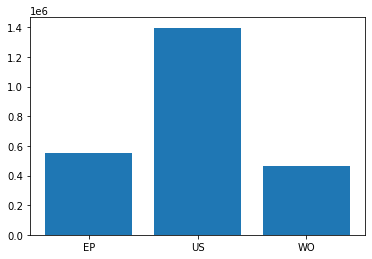

In [5]:
print(Counter(DF['patent_office']))
plot1 = Counter(DF['patent_office'])
plt.bar(plot1.keys(), plot1.values())
plt.show()

### Remove label column which is not needed

In [6]:
if classification_selection==1:
    DF=DF.rename(columns={'classification_ipcr': 'labels'})
    if 'main_classification' in DF.columns:
        del DF['main_classification']
    if 'further_classification' in DF.columns:
        del DF['further_classification']
    if 'classification_cpc' in DF.columns:
        del DF['classification_cpc'] 
elif classification_selection==2:
    DF=DF.rename(columns={'classification_cpc': 'labels'})
    if 'main_classification' in DF.columns:
        del DF['main_classification']
    if 'further_classification' in DF.columns:
        del DF['further_classification']
    if 'classification_ipcr' in DF.columns:
        del DF['classification_ipcr'] 
else:
    print("Please provide a valid value for classification_selection")
DF.head(1)

,Unnamed: 0,xml_file_name,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office
0,0,EP-2677851-A1.xml,EP-2677851-A1,20140101.0,A01B 79/005 20130101 LI20150420BHEP ...,1.0,1.0,1.0,2677851,EP


In [7]:
#pd.set_option("max_colwidth",None)
#pd.set_option("max_rows", None)

### VP - Unify all different versions of a patent into one single patent

In [8]:
# make abstract, description and claims values int
cols_to_replace = ['abstract_lang_en_exist', 'description_lang_en_exist', 'claims_lang_en_exist']
DF[cols_to_replace] = DF[cols_to_replace].astype(int)

# if these columns have a zero, make it an empty cell, 
#then, group according to the patent number keeping the latest non empty entry
DF['abstract_lang_en_exist'] = DF['abstract_lang_en_exist'].replace({0:np.nan})
DF['description_lang_en_exist'] = DF['description_lang_en_exist'].replace({0:np.nan})
DF['claims_lang_en_exist'] = DF['claims_lang_en_exist'].replace({0:np.nan})
DF=DF.groupby('patent_number').agg({'ucid': lambda x: ','.join(map(str, x)), 'date':'first', \
                                    'labels':'last','abstract_lang_en_exist':'last', 'description_lang_en_exist': 'last', \
                                        'claims_lang_en_exist':'last', 'patent_number':'last', 'patent_office': 'last'})

# create a help column and keep patents having all textual sections completed
DF['adc_exist']= None
DF['adc_exist']=DF['abstract_lang_en_exist']+DF['description_lang_en_exist']+DF['claims_lang_en_exist']
DF=DF[DF['adc_exist']==3]
DF = DF.reset_index(drop=True)
del DF['adc_exist']

DF.shape

(1806834, 8)

In [9]:
# confirmed that same patent numbers do not contain across different patent officies
# Counter(DF['patent_office'])

### Remove single patents that do not have labels

In [10]:
DF['labels']=DF['labels'].fillna("")
DF=DF[DF['labels']!='']
DF.shape

(1806774, 8)

### Suffle the remaining patents

In [11]:
DF = shuffle(DF, random_state=42)

### Transform labels into groups and remove duplicates

In [12]:
DF['labels'] = DF['labels'].str.split(',')
DF['labels'] = DF['labels'].apply(lambda x: [item.split('/')[0] for item in x])
DF['labels'] = DF['labels'].apply(lambda x: [item.replace(" ", "") for item in x])
DF['labels'] = DF['labels'].apply(lambda x: list(dict.fromkeys(x)))
DF.head(5)

,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office
64635,US-20140060989-A1,20140306.0,"[A45C13, A45C5, A45C9]",1.0,1.0,1.0,20140060989,US
143230,US-20140135764-A1,20140515.0,"[A61F5, A61B17]",1.0,1.0,1.0,20140135764,US
330280,US-20140313921-A1,20141023.0,"[H04W72, H04L1, G01D21, H04W84, H04W28, H04W88...",1.0,1.0,1.0,20140313921,US
135472,US-20140128458-A1,20140508.0,"[C07D493, C07D307, A61K31, C07D405]",1.0,1.0,1.0,20140128458,US
1212635,US-8626610-B2,20140107.0,"[G06Q10, G06Q30]",1.0,1.0,1.0,8626610,US


### Transform labels containing only the subclass part into subclasses

In [13]:
#E.g. A01N20060101SI20051110RMEP comes from A01N 20060101S I20051110RMEP which contains only a subclass
target_substring = "RMEP" 
DF[DF['labels'].apply(lambda label_list: any(target_substring in str(item) for item in label_list))].head(1)

,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office


In [14]:
def tranform_into_subclass(label_string):
    if "RMEP" in label_string:
        return label_string[:4]
    else:
        return label_string
    
DF['labels'] = DF['labels'].apply(lambda label_list: [tranform_into_subclass(item) for item in label_list])

target_substring = "RMEP" 
DF[DF['labels'].apply(lambda label_list: any(target_substring in str(item) for item in label_list))].head(1)

,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office


### Explode and wrap each label in a list

In [16]:
DF = DF.explode('labels').reset_index(drop=True)
DF['labels'] = DF['labels'].astype(str)
DF.head(6)

,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,patent_office
0,US-20140060989-A1,20140306.0,A45C13,1.0,1.0,1.0,20140060989,US
1,US-20140060989-A1,20140306.0,A45C5,1.0,1.0,1.0,20140060989,US
2,US-20140060989-A1,20140306.0,A45C9,1.0,1.0,1.0,20140060989,US
3,US-20140135764-A1,20140515.0,A61F5,1.0,1.0,1.0,20140135764,US
4,US-20140135764-A1,20140515.0,A61B17,1.0,1.0,1.0,20140135764,US
5,US-20140313921-A1,20141023.0,H04W72,1.0,1.0,1.0,20140313921,US


### Remove labels of Y section (starting from "Y")

In [17]:
print("Before removing Y labels:", DF.shape[0])
DF=DF[~DF['labels'].str.startswith("Y")]
print("After removing Y labels:", DF.shape[0])

Before removing Y labels: 7233913
After removing Y labels: 6858119


### Remove codes under a threshold and keep a portion
Follows the "Take at least 1" strategy for low-frequency labels

In [18]:
def remove_rare_codes(trainDF, down_threshold, portion):
    
    print("Size of initial data:", trainDF.shape)
    
    label_counts=Counter(trainDF['labels'])
    
    valid_labels = {label for label, count in label_counts.items() if count >= down_threshold}
    filtered_df = trainDF[trainDF['labels'].isin(valid_labels)].copy()    
    label_counts_valid=Counter(filtered_df['labels'])

    trainDF = pd.DataFrame()

    for code, freq in label_counts_valid.items():    
        label_sum=0                      
        new_freq=int(freq*portion)
        
        # Take at least 1 strategy
        if new_freq==0:
            new_freq=1

        code_specific_rows = filtered_df[filtered_df['labels'] == code]
        code_specific_rows =code_specific_rows.head(new_freq)
                
        trainDF=pd.concat([trainDF, code_specific_rows])
        #print(trainDF.shape)
    
    print("Size of final data:", trainDF.shape)
    
    label_counts_validated=Counter(trainDF['labels'])
    print(label_counts_validated) 
    
    return trainDF

### The down threshold was set to 20 and 5% sampling portion was applied.

In [19]:
DF2=remove_rare_codes(DF, 20, 0.05)     

Size of initial data: (6858119, 8)
Size of final data: (337846, 8)
Counter({'G06F3': 3937, 'G06F17': 3928, 'A61K31': 2614, 'H01L21': 2483, 'H04L67': 2409, 'H01L27': 1948, 'H04W4': 1868, 'G06Q30': 1818, 'H04N5': 1774, 'H04L63': 1766, 'H01L2924': 1747, 'G06F9': 1733, 'A61B5': 1730, 'G01N33': 1694, 'G06F21': 1655, 'G06Q10': 1630, 'H01L29': 1586, 'H04N21': 1465, 'G06F1': 1412, 'A61B17': 1406, 'H04W72': 1386, 'G06F11': 1369, 'A61K9': 1369, 'G06K9': 1333, 'H01L23': 1299, 'H04L12': 1194, 'H01L2224': 1184, 'A61B2017': 1148, 'G06F19': 1108, 'A61K45': 1070, 'C12Q1': 1059, 'A61K38': 1057, 'H04L5': 1036, 'C12N15': 1006, 'G02F1': 995, 'G06Q50': 989, 'H04L41': 979, 'A61K47': 973, 'H04W88': 969, 'G06T7': 952, 'H04M1': 952, 'A61F2': 932, 'G06T2207': 915, 'C07K14': 908, 'H04L1': 902, 'H04W84': 864, 'H04L65': 862, 'H04B7': 857, 'H04W76': 852, 'G02B6': 840, 'H01M10': 817, 'H04N7': 801, 'H04W24': 791, 'G01N21': 786, 'C07K16': 784, 'G06Q20': 777, 'H04N1': 756, 'H04W12': 754, 'G06F12': 750, 'H04B1': 742, 'H

### Combine the labels of the same patent which was previously exploded and wraped 

In [20]:
# It doesn't matter whether we keep the first or last value for each field, since all exploded rows differ only by the label value
DF2_combined=DF2.groupby('patent_number').agg({'ucid': 'last', 'date':'last', 'labels': lambda x: ','.join(map(str, x)),\
                                      'abstract_lang_en_exist':'last', 'description_lang_en_exist': 'last', \
                                        'claims_lang_en_exist':'last', 'patent_number':'last', 'patent_office':'last'})
DF2_combined.shape

(97063, 8)

In [21]:
label_counts=Counter(DF2['labels'])
print("Number of labels:",len(label_counts), "and number of combined patents:", DF2_combined.shape[0])

Number of labels: 7984 and number of combined patents: 97063


In [22]:
DF2_combined.to_csv('/PATH/WPI-Dataset/EP_US_WO_all_cpc_combined.csv', index=False)

In [22]:
#DF2_combined = pd.read_csv('F:/PhD/Test collections/WPI-Dataset/EP_US_WO_all_ipcr_thres20_portion5_take1strategy_combined.csv', header=0)
#DF2_combined

# Analysis of labels

### Find the group labels and their frequencies

In [36]:
# Split the 'labels' column by commas
DF_2=df_test.copy()

DF_2['labels'] = DF_2['labels'].str.split(',')

# Extract the first part of each label after splitting by '/'
DF_2['labels'] = DF_2['labels'].apply(lambda x: [item.split('/')[0] for item in x])
DF_2['labels'] = DF_2['labels'].apply(lambda x: [item.replace(" ", "") for item in x])

expanded_DF=DF_2['labels'].apply(pd.Series)

# Transform 'na' values of the expanded table into empty content cells
expanded_DF=expanded_DF.fillna("")

# Infer the group label (delete the last I/N character and  empty spaces from the beginning/end - if any)
nums=expanded_DF.shape[1]
for num in range (nums):
    expanded_DF[num]=expanded_DF[num].str.strip()

# Create a new table with group labels and their frequencies
total_counter = Counter()

for num in range(nums):
    exec(f'counter_{num} = Counter(expanded_DF[num])')
    exec(f'total_counter=total_counter+counter_{num}')

code_, freq_ = [], []

for code, freq in total_counter.items():
    code_.append(code)
    freq_.append(freq)

DF_codes = pd.DataFrame()
DF_codes['code'] = code_
DF_codes['freq'] = freq_

# Delete empty rows
DF_codes=DF_codes[DF_codes['code']!='']

# Sort based on freq
DF_codes=DF_codes.sort_values(by = 'freq', ascending=True)

print(DF_codes.shape, DF_codes['freq'].sum())
DF_codes

(4687, 2) 33582


,code,freq
4687,B32B2603,1
3473,F02D17,1
3475,C07C15,1
3476,B64D47,1
1430,A44C5,1
...,...,...
65,H04W4,217
26,H01L21,224
167,H04L67,267
38,G06F3,406


### Find the subclass labels and their frequencies

In [37]:
DF_subclass=DF_codes.copy()
DF_subclass['code_subclass']= None
DF_subclass=DF_subclass.reset_index(drop=True)
for i in range (DF_subclass['code'].shape[0]):
    DF_subclass.loc[i, 'code_subclass']=DF_subclass['code'][i][0:4]
DF_subclass['freq_subclass'] = DF_subclass.groupby('code_subclass')['freq'].transform('sum')
DF_subclass = DF_subclass.drop_duplicates(subset = ["code_subclass"])
DF_subclass=DF_subclass.sort_values(by = 'freq_subclass', ascending=True)
DF_subclass=DF_subclass.reset_index(drop=True)

print(DF_subclass.shape, DF_subclass['freq_subclass'].sum())
DF_subclass

(561, 4) 33582


,code,freq,code_subclass,freq_subclass
0,A63D5,1,A63D,1
1,B23F17,1,B23F,1
2,F24T10,1,F24T,1
3,D01B1,1,D01B,1
4,C08C19,1,C08C,1
...,...,...,...,...
556,A61K2121,1,A61K,990
557,H04W80,9,H04W,1307
558,H01L2031,1,H01L,1471
559,H04L2007,1,H04L,1474


### Plot the distribution of patents per section label

No handles with labels found to put in legend.


(8, 6) 337846


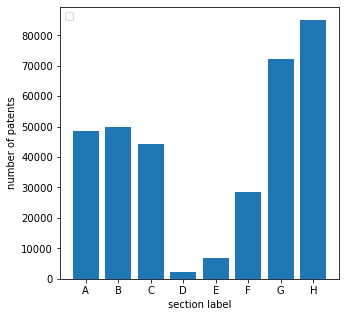

In [25]:
# Prepare the plot: labels_section vs number_patents
DF_plot1_c=DF_subclass.copy()
DF_plot1_c['code_section']= None
DF_plot1_c=DF_plot1_c.reset_index(drop=True)
for i in range (DF_plot1_c['code'].shape[0]):
    DF_plot1_c.loc[i, 'code_section']=DF_plot1_c['code'][i][0:1]
DF_plot1_c['freq_section'] = DF_plot1_c.groupby('code_section')['freq_subclass'].transform('sum')
DF_plot1_c = DF_plot1_c.drop_duplicates(subset = ["code_section"])
DF_plot1_c=DF_plot1_c.sort_values(by = 'code_section', ascending=True)
DF_plot1_c=DF_plot1_c.reset_index(drop=True)

print(DF_plot1_c.shape, DF_plot1_c['freq_section'].sum())

x = DF_plot1_c['code_section']
y = DF_plot1_c['freq_section']

fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches

plt.bar(x,y)#,label="")

plt.xlabel("section label")
plt.ylabel("number of patents")
plt.title("")
plt.legend()
plt.show()

Counter({'US': 73109, 'EP': 12197, 'WO': 11757})


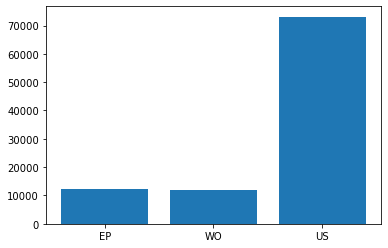

In [26]:
print(Counter(DF2_combined['patent_office']))
plot1 = Counter(DF2_combined['patent_office'])
plt.bar(plot1.keys(), plot1.values())
plt.show()

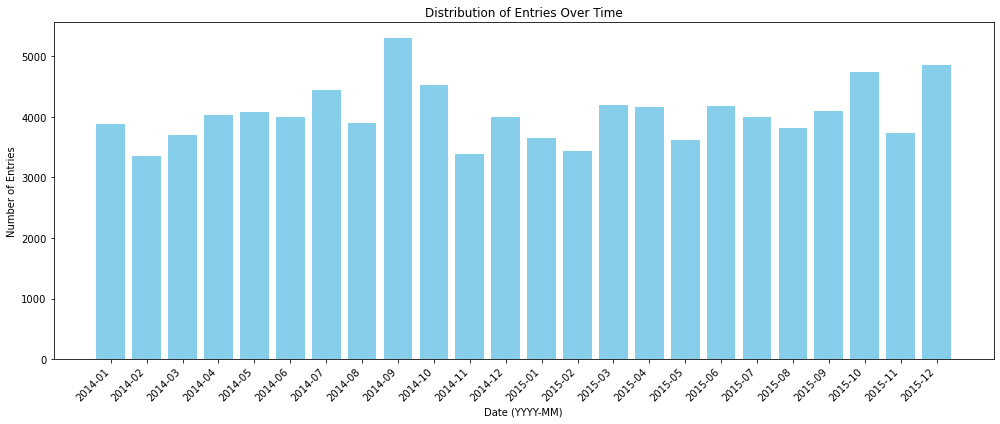

In [27]:
DF2_combined['date']=DF2_combined['date'].astype(str)

DF2_combined['month'] = DF2_combined['date'].str[:6]
plot2 = Counter(DF2_combined['month'])

# Sort by date
plot2_sorted = dict(sorted(plot2.items()))

# Convert keys to 'YYYY-MM' format
labels = [f"{x[:4]}-{x[4:]}" for x in plot2_sorted.keys()]
values = list(plot2_sorted.values())

# Plot
plt.figure(figsize=(14, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Entries')
plt.title('Distribution of Entries Over Time')
plt.tight_layout()
plt.show()

In [29]:
from skmultilearn.model_selection import iterative_train_test_split
mlb = MultiLabelBinarizer()

def balanced_split(df, mlb, test_size=0.1):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    mlb.fit_transform(df["labels"])
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind, labels, test_size
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]


df_train, df_valid_test = balanced_split(DF2_combined, mlb, test_size=0.2)
df_valid, df_test = balanced_split(df_valid_test, mlb, test_size=0.5)
print(df_train.shape, df_valid.shape, df_test.shape)

(77199, 9) (10013, 9) (9851, 9)


In [32]:
DF_subclass_list_train_s=DF_subclass['code_subclass'].tolist()
DF_subclass_list_train_g=DF_codes['code'].tolist()

print("Train subclasses:", len(DF_subclass_list_train_s), "Train groups:", len(DF_subclass_list_train_g))

Train subclasses: 619 Train groups: 7729


In [35]:
DF_subclass_list_valid_s=DF_subclass['code_subclass'].tolist()
DF_subclass_list_valid_g=DF_codes['code'].tolist()

print("Valid subclasses:", len(DF_subclass_list_valid_s), "Valid groups:", len(DF_subclass_list_valid_g))

Valid subclasses: 562 Valid groups: 4752


In [38]:
DF_subclass_list_test_s=DF_subclass['code_subclass'].tolist()
DF_subclass_list_test_g=DF_codes['code'].tolist()

print("Test subclasses:", len(DF_subclass_list_test_s), "Test groups:", len(DF_subclass_list_test_g))

Test subclasses: 561 Test groups: 4687


In [28]:
DF_subclass_list_all_s=DF_subclass['code_subclass'].tolist()
DF_subclass_list_all_g=DF_codes['code'].tolist()

print("All subclasses:", len(DF_subclass_list_all_s), "All groups:", len(DF_subclass_list_all_g))

All subclasses: 621 All groups: 7984


### Differences

#### Group

In [39]:
diff1 = list(set(DF_subclass_list_valid_g) - set(DF_subclass_list_train_g))
print("In valid but not in train set:", len(diff1))
diff2 = list(set(DF_subclass_list_train_g) - set(DF_subclass_list_valid_g))
print("In train but not in valid set:", len(diff2))

In valid but not in train set: 143
In train but not in valid set: 3120


In [40]:
diff1 = list(set(DF_subclass_list_test_g) - set(DF_subclass_list_train_g))
print("In test but not in train set:", len(diff1))
diff2 = list(set(DF_subclass_list_train_g) - set(DF_subclass_list_test_g))
print("In train but not in test set:", len(diff2))

In test but not in train set: 138
In train but not in test set: 3180


#### Subclass

In [41]:
diff1 = list(set(DF_subclass_list_valid_s) - set(DF_subclass_list_train_s))
print("In valid but not in train set:", len(diff1))
diff2 = list(set(DF_subclass_list_train_s) - set(DF_subclass_list_valid_s))
print("In train but not in valid set:", len(diff2))

In valid but not in train set: 1
In train but not in valid set: 58


In [42]:
diff1 = list(set(DF_subclass_list_test_s) - set(DF_subclass_list_train_s))
print("In test but not in train set:", len(diff1))
diff2 = list(set(DF_subclass_list_train_s) - set(DF_subclass_list_test_s))
print("In train but not in test set:", len(diff2))

In test but not in train set: 1
In train but not in test set: 59


In [43]:
df_train.to_csv('/PATH/WPI-Dataset/EP_US_WO_all_cpc_train.csv', index=False)
df_valid.to_csv('/PATH/WPI-Dataset/EP_US_WO_all_cpc_valid.csv', index=False)
df_test.to_csv('/PATH/WPI-Dataset/EP_US_WO_all_cpc_test.csv', index=False)